# XGBOOST Model Applications
The trained and validated model can be used to make predictions on unlabeled data. For example, we can use it on the 'predict_past' data set that corresponds to data prior to June 2003 (when delay causes were not included with the flight records). This enables us to make the database consistent and enables other applications that require delay attribution to be look further back in time. Similarly, new data (actual or simulated) can be labelled based on the trained model. 

In [1]:
import gc
import os
import sys
import glob
import shutil
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
from pandas.api.types import CategoricalDtype
import numpy as np
from time import time
from datetime import datetime

import dask
import dask.dataframe as dd
from dask.distributed import Client, wait, progress, get_worker

import sklearn
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost.dask import DaskDMatrix

print('xgboost version', xgb.__version__)

run_type = 'gpu'
max_depth = 15
num_boost_round = 200
score_metric = 'auc'
storage_backend = 'local'

test_size = 0.01 # Non-zero to pass data split checker. Value not used since data previously partitioned into test/train folders.
   
study_arpt = 'NAS'

if study_arpt == 'NAS':
    # NAS processing excludes weather. Has additional cols for arrival/departure airports.
    pred_model = 'multi_class'
    label_col = 'DELAY_CAUSES_ENC'
    excluded_features = [label_col, 'cv_idx', 'UID', 'ARR_DEL15', 'DEP_DEL15', 'YYYYMM']
else:
    pred_model = 'binary_class'
    label_col = 'ARR_DEL15'
    excluded_features = [label_col, 'cv_idx', 'UID', 'DEL_ARR_PER_QTHR', 'DEL_DEP_PER_QTHR', 'DEP_DEL15', 'ARR_DEL']

if pred_model == 'binary_class':
    xgb_objective = 'binary:logistic'
elif pred_model == 'multi_class':
    # xgboost auc docs mentioned that: "When used with multi-class classification, objective should be multi:softprob instead of multi:softmax, 
    # as the latter doesn’t output probability. Also the AUC is calculated by 1-vs-rest with reference class weighted by class prevalence."
    xgb_objective = 'multi:softprob'
# elif pred_model == 'regression':
#     label_col = 'ARR_DELAY' # Regression model
#     xgb_objective = 'reg:squarederror'
    
partial_enc_input_dir = './data/encoded/'+study_arpt # Partially encoded data. Target encoding required.
enc_output_dir = './data/encoded/split/'+study_arpt

xgb_model_name = 'xgb_'+run_type+'_airline_delay_'+study_arpt+'_max_depth_'+str(max_depth)

# client = Client('tcp://192.168.1.232:8786')

if run_type == 'gpu':
    from dask_cuda import LocalCUDACluster
    import cupy as cp
    
    # Run on all available GPU on same machine:
    cluster = LocalCUDACluster(threads_per_worker=16, memory_limit='128GB')
    client = Client(cluster)
    
    # Run single GPU:
#     client = Client(n_workers=1, threads_per_worker=32)
elif run_type == 'cpu':
    client = Client(n_workers=1, threads_per_worker=32)    
    
client

xgboost version 1.5.0


/home/btong/miniconda3/envs/rapids-21.12/lib/python3.8/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43461 instead
  warnings.warn(
distributed.preloading - INFO - Import preload module: dask_cuda.initialize
distributed.preloading - INFO - Import preload module: dask_cuda.initialize


Connection method: Cluster object,Cluster type: dask_cuda.LocalCUDACluster
Dashboard: http://127.0.0.1:43461/status,
Dashboard: http://127.0.0.1:43461/status,Workers: 2
Total threads: 32,Total memory: 238.42 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45673,Workers: 2
Dashboard: http://127.0.0.1:43461/status,Total threads: 32
Started: Just now,Total memory: 238.42 GiB
Comm: tcp://127.0.0.1:38419,Total threads: 16
Dashboard: http://127.0.0.1:39073/status,Memory: 119.21 GiB
Nanny: tcp://127.0.0.1:45647,


In [2]:
%%time

def dask_xgb_predict_output(client, run_type, model_file, data_path, label_col):
    """
    Use dask + xgboost for inferencing against already encoded data.
    """    
    if run_type == 'gpu':
        import dask_cudf as hw # Needed for xgb.dask.inplace_predict(). 
#         import dask.dataframe as hw # Has internal switching for compatibility. Takes a long time to perform AUC score, but fast at prediction.
    else:
        import dask.dataframe as hw
    
    model = xgb.Booster(model_file=model_file+'.model')
    
    ddf_enc = hw.read_parquet(data_path).persist()

    # Format data for xgboost:
    feature_cols = [cc for cc in ddf_enc.columns if cc not in excluded_features]
    X = ddf_enc[feature_cols].astype('float32')
    y = ddf_enc[label_col].astype('float32')

    # Run predictions:
    tic = time()
    model.set_param('predictor', run_type + '_predictor')
    model = client.scatter(model, broadcast=True)

    # IMPORTANT: X.values required to get consistent CPU scoring. Issue with column ordering in dask.dataframe?
    y_pred = xgb.dask.inplace_predict(client, model, X.values) # Use inplace_predict() can sometimes be faster.

    # Force computation of y's required for libraries without dask.dataframe support:
    y_pred = y_pred.compute()
    y = y.compute()

    predict_time = np.round(time() - tic, 2)
    gc.collect()
    return(y_pred, y)


y_pred, y = dask_xgb_predict_output(client, run_type, xgb_model_name, enc_output_dir+'/test', label_col)

CPU times: user 1.89 s, sys: 529 ms, total: 2.42 s
Wall time: 7.58 s


In [3]:
def score_pred(run_type, y_true, y_pred, score_metric):
    """
    Prediction scoring function.
    """
    if pred_model == 'multi_class':
        # Scoring for multi-class is done on CPU only. cuML roc_auc_score doesn't not work with multi-class yet.
        # Work-around is to use CPU for scoring via converting gpu-dataframe to pandas.
        if run_type == 'gpu':
            import cupy
            y_true = cupy.asnumpy(y_true)
            y_pred = cupy.asnumpy(y_pred)
            
            # Update run_type to bypass GPU methods.
            run_type = 'cpu'
    
    if run_type == 'gpu':
#         import dask.dataframe as hw # Has internal switching for compatibility. Takes a long time to perform AUC score, but fast at prediction.
        from cuml.metrics import roc_auc_score
        from cuml.metrics.accuracy import accuracy_score
        # TODO: inplace scoring to pair with inplace prediction? Only works with certain methods.
    else:
        # TODO: need parallelized roc_auc_score computation for auc.
        from sklearn.metrics import roc_auc_score # Single-threaded?
#         from sklearn.metrics import accuracy_score # Single-threaded
        from dask_ml.metrics import accuracy_score # CPU parallelized

    if score_metric == 'auc':
        if pred_model == 'multi_class':
            # xgb multi-class classification uses One-vs-Rest (or One-vs-All): 
            score_value = roc_auc_score(y_true, y_pred, multi_class='ovr', average='macro')
            
            # Only support average param of: 
                # 'macro' (default): Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.)
                # 'weighted': Calculate metrics for each label, and find their average, weighted by support (the number of true instances for each label).
                
            # Use average='macro' so model takes extreme imbalance of minority classes into consideration within score.
        else:
            # AUC uses probabilities. https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html
            score_value = roc_auc_score(y_true, y_pred)
    elif score_metric == 'acc':
        # Accuracy score uses threshold value due to ==. https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
        score_value = accuracy_score(y_true.round(), y_pred.round()) # y_pred needs to be converted explicitly. Dask doesn't know shape of y, y_pred if dask.dataframe.
    return(score_value)

score_pred(run_type, y, y_pred, 'auc')

0.9881271599187992

# Examine Individual Model Predictions

In [4]:
if run_type == 'gpu':
    # Convert data to CPU data formats to use visualization libraries.
    y = cp.asnumpy(y)
    y_pred = cp.asnumpy(y_pred)
    
# Determine most likely class based on individual binary predictions:
y_pred_class = np.argmax(y_pred, axis=1)

test_pred = pd.DataFrame({'y_true': y, 'y_pred_class': y_pred_class})
test_pred['y_true'] = test_pred['y_true'].astype(int)
test_pred['match'] = test_pred['y_true'] == test_pred['y_pred_class']
test_pred

,y_true,y_pred_class,match
0,0,0,True
1,0,0,True
2,0,0,True
3,0,0,True
4,0,0,True
...,...,...,...
321805,0,0,True
321806,0,0,True
321807,0,0,True
321808,0,0,True


In [5]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

num_classes = int(np.max(y)+1)

meta_class_cnts = pd.read_csv('./data/staging_tbl/class_labels.csv')

# Truncate at last class:
meta_class_cnts = meta_class_cnts[:num_classes]
class_labels = list(meta_class_cnts['CLASS_STR'].values)
class_labels = class_labels[:-1] + ['OOOO']

# Use appropriate metrics for evaluating multi-class predictions.
print(classification_report(y, y_pred_class, target_names=class_labels))

# F1 score = 2*(precision*recall)/(precision + recall)

# Compute confusion matrix:
cf_matrix = confusion_matrix(y, y_pred_class)

              precision    recall  f1-score   support

        ----       1.00      1.00      1.00    291870
        -C--       0.50      0.81      0.62      8315
        --N-       0.95      0.77      0.86      6312
        -CN-       0.50      0.67      0.57      3547
        L---       0.37      0.20      0.26      3191
        LC--       0.42      0.35      0.38      3640
        L-N-       0.35      0.10      0.16      1724
        LCN-       0.33      0.09      0.14      1573
        OOOO       0.35      0.16      0.22      1638

    accuracy                           0.96    321810
   macro avg       0.53      0.46      0.47    321810
weighted avg       0.96      0.96      0.96    321810



Text(84.5, 0.5, 'Actual')

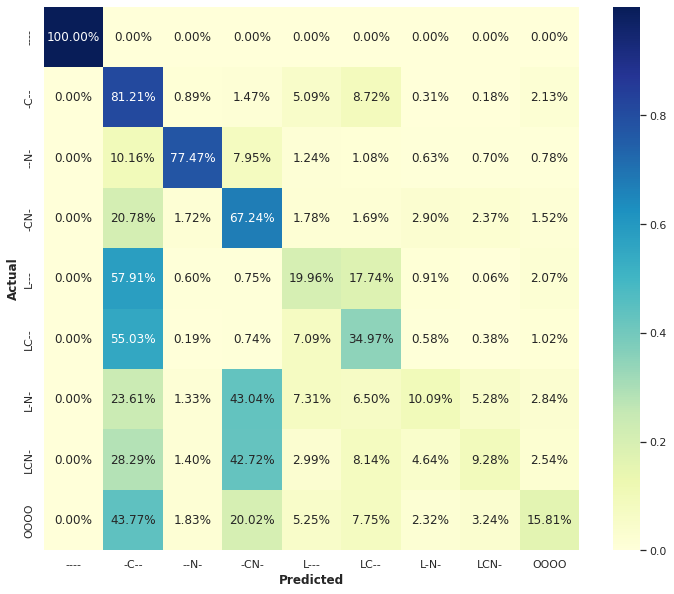

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(12, 10)})

# Applying normalize param in sklearn.metrics.confusion_matrix results in 
# normalize='pred': precision along main diag. Matrix column sums to 1.  
# normalize='true': recall along the main diag. Matrix row sums to 1.
cf_matrix = confusion_matrix(y, y_pred_class, normalize='true')

sns.heatmap(cf_matrix, annot=True, fmt='.2%', cmap='YlGnBu',
           xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel('Predicted', fontsize=12, weight='bold')
plt.ylabel('Actual', fontsize=12, weight='bold')

# Original class labels based on ranked prevalance. Based on visual inspection, we may be able to 
# reduce down to 5 meta-classes (instead of original 9) due to class overlap.
# LATE_AIRCRAFT_DELAY and CARRIER_DELAY difficult to distinguish.
# 

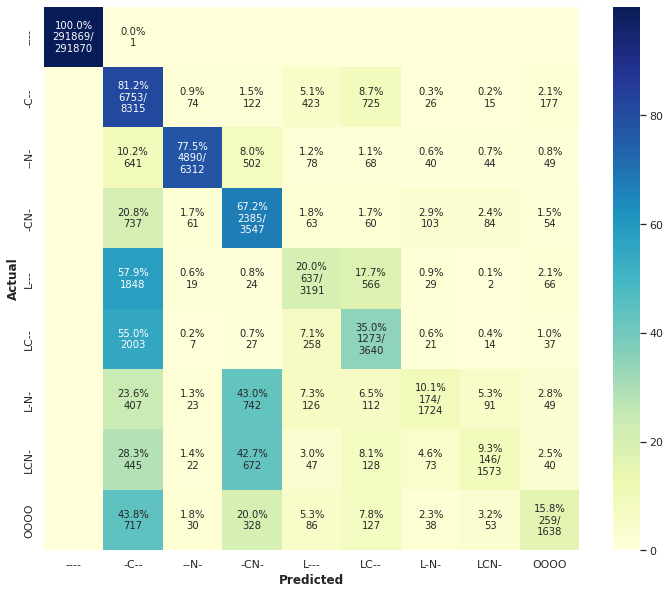

In [7]:
# Alternative confusion matrix plotting which displays sample size. 

import matplotlib.pyplot as plt
%matplotlib inline

# Plotting code modified from: https://www.kaggle.com/agungor2/various-confusion-matrix-plots?scriptVersionId=12813038&cellId=4
def plot_cm(y_true, y_pred, figsize=(12,10)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/\n%d' % (p, c, s)
#                 annot[i, j] = '%.1f%%\n%d' % (p, c)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
                
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    
#     sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)
    
    # Column normalized confusion matrix:
    sns.heatmap(cm_perc, cmap= "YlGnBu", annot=annot, fmt='', ax=ax, 
                xticklabels=class_labels, yticklabels=class_labels
               )
    
    plt.xlabel(cm.columns.name, fontsize=12, weight='bold')
    plt.ylabel(cm.index.name, fontsize=12, weight='bold')
    return(cm_perc)
    
# Results row normalized (i.e., each row adds up to 100%). Main diagonal represents recall.
cm_perc = plot_cm(y, y_pred_class)